# Low-loss mode connectivity between two CIFAR-10 ResNet18 checkpoints
This notebook contains everything needed to:
1. Load pretrained endpoints trained outside the repo.
2. Wrap them in curve-aware layers (Bezier parameterization).
3. Train the intermediate bend(s) directly inside the notebook.
4. Evaluate and visualize loss/accuracy along the path.



In [1]:
import math
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models import (
    ResNet101_Weights,
    ResNet152_Weights,
    ResNet18_Weights,
    ResNet34_Weights,
    ResNet50_Weights,
    resnet101,
    resnet152,
    resnet18,
    resnet34,
    resnet50,
)

torch.manual_seed(0)


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def select_device():
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device


def get_cifar10_loaders(data_dir: str, batch_size: int = 128, num_workers: int = 4):
    train_tfms = torchvision.transforms.Compose([
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        ),
    ])

    test_tfms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        ),
    ])

    train_set = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=train_tfms
    )
    test_set = torchvision.datasets.CIFAR10(
        data_dir, train=False, download=True, transform=test_tfms
    )

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return train_loader, test_loader, train_set.classes

In [3]:
class Bezier(nn.Module):
    def __init__(self, num_bends: int):
        super().__init__()
        coeffs = torch.tensor([math.comb(num_bends - 1, k) for k in range(num_bends)], dtype=torch.float32)
        rng = torch.arange(0, float(num_bends))
        self.register_buffer("binom", coeffs)
        self.register_buffer("powers", rng)
        self.register_buffer("rev_powers", torch.flip(rng, dims=[0]))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.binom * t.pow(self.powers) * (1.0 - t).pow(self.rev_powers)


class CurveModule(nn.Module):
    def __init__(self, fix_points, parameter_names=()):
        super().__init__()
        self.fix_points = fix_points
        self.parameter_names = parameter_names
        self.num_bends = len(fix_points)
        self.l2 = 0.0

    def compute_weights_t(self, coeffs_t):
        w_t = [None] * len(self.parameter_names)
        self.l2 = 0.0
        for i, parameter_name in enumerate(self.parameter_names):
            for j, coeff in enumerate(coeffs_t):
                parameter = getattr(self, f"{parameter_name}_{j}")
                if parameter is None:
                    continue
                contribution = parameter * coeff
                w_t[i] = contribution if w_t[i] is None else w_t[i] + contribution
            if w_t[i] is not None:
                self.l2 += torch.sum(w_t[i] ** 2)
        return w_t


class CurveLinear(CurveModule):
    def __init__(self, in_features, out_features, fix_points, bias=True):
        super().__init__(fix_points, ("weight", "bias"))
        self.in_features = in_features
        self.out_features = out_features
        for idx, fixed in enumerate(self.fix_points):
            self.register_parameter(
                f"weight_{idx}",
                nn.Parameter(torch.empty(out_features, in_features), requires_grad=not fixed),
            )
            if bias:
                self.register_parameter(
                    f"bias_{idx}", nn.Parameter(torch.empty(out_features), requires_grad=not fixed)
                )
            else:
                self.register_parameter(f"bias_{idx}", None)
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1.0 / math.sqrt(self.in_features)
        for idx in range(self.num_bends):
            getattr(self, f"weight_{idx}").data.uniform_(-bound, bound)
            bias = getattr(self, f"bias_{idx}")
            if bias is not None:
                bias.data.uniform_(-bound, bound)

    def forward(self, x, coeffs_t):
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return nn.functional.linear(x, weight_t, bias_t)


class CurveConv2d(CurveModule):
    def __init__(self, in_channels, out_channels, kernel_size, fix_points, stride=1, padding=0, bias=False):
        super().__init__(fix_points, ("weight", "bias"))
        kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        for idx, fixed in enumerate(self.fix_points):
            self.register_parameter(
                f"weight_{idx}",
                nn.Parameter(
                    torch.empty(out_channels, in_channels, *kernel_size),
                    requires_grad=not fixed,
                ),
            )
            if bias:
                self.register_parameter(
                    f"bias_{idx}", nn.Parameter(torch.empty(out_channels), requires_grad=not fixed)
                )
            else:
                self.register_parameter(f"bias_{idx}", None)
        self.stride = stride
        self.padding = padding
        self.reset_parameters()

    def reset_parameters(self):
        for idx in range(self.num_bends):
            weight = getattr(self, f"weight_{idx}")
            nn.init.kaiming_normal_(weight, mode="fan_out", nonlinearity="relu")
            bias = getattr(self, f"bias_{idx}")
            if bias is not None:
                bias.data.zero_()

    def forward(self, x, coeffs_t):
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return nn.functional.conv2d(x, weight_t, bias_t, stride=self.stride, padding=self.padding)


class _CurveBatchNorm(CurveModule):
    def __init__(self, num_features, fix_points, eps=1e-5, momentum=0.1):
        super().__init__(fix_points, ("weight", "bias"))
        self.eps = eps
        self.momentum = momentum
        self.track_running_stats = True
        for idx, fixed in enumerate(self.fix_points):
            self.register_parameter(
                f"weight_{idx}",
                nn.Parameter(torch.ones(num_features), requires_grad=not fixed),
            )
            self.register_parameter(
                f"bias_{idx}",
                nn.Parameter(torch.zeros(num_features), requires_grad=not fixed),
            )
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))
        self.register_buffer("num_batches_tracked", torch.tensor(0, dtype=torch.long))

    def reset_running_stats(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.num_batches_tracked.zero_()

    def forward(self, x, coeffs_t):
        self.num_batches_tracked += 1
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return nn.functional.batch_norm(
            x,
            self.running_mean,
            self.running_var,
            weight_t,
            bias_t,
            self.training or not self.track_running_stats,
            self.momentum,
            self.eps,
        )


class CurveBatchNorm2d(_CurveBatchNorm):
    pass


class CurveSequential(nn.Sequential):
    def forward(self, x, coeffs_t):
        for module in self:
            if isinstance(module, CurveModule):
                x = module(x, coeffs_t)
            else:
                x = module(x)
        return x


def curve_l2_regularizer(weight_decay: float):
    return lambda model: 0.5 * weight_decay * sum(m.l2 for m in model.curve_modules)


class CurveNet(nn.Module):
    def __init__(self, base_constructor, curve_constructor, num_classes, num_bends=3, fix_start=True, fix_end=True, **kwargs):
        super().__init__()
        self.num_bends = num_bends
        self.fix_points = [fix_start] + [False] * (num_bends - 2) + [fix_end]
        self.coeff_layer = Bezier(num_bends)
        self.net = curve_constructor(num_classes=num_classes, fix_points=self.fix_points, **kwargs)
        self.curve_modules = [module for module in self.net.modules() if isinstance(module, CurveModule)]
        self.base_constructor = base_constructor
        self.kwargs = kwargs
        self.num_classes = num_classes

    def import_base_parameters(self, base_model, index):
        """Import parameters from base_model into the curve model at bend index"""
        def get_curve_modules(model):
            """Recursively get curve modules in forward pass order"""
            modules = []
            for child in model.children():
                if isinstance(child, CurveModule):
                    modules.append(child)
                else:
                    modules.extend(get_curve_modules(child))
            return modules
        
        def get_base_modules(model):
            """Recursively get base modules in forward pass order"""
            modules = []
            for child in model.children():
                if isinstance(child, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
                    modules.append(child)
                elif isinstance(child, nn.Sequential):
                    # Sequential contains modules, recurse into it
                    modules.extend(get_base_modules(child))
                elif isinstance(child, nn.ModuleList):
                    # ModuleList contains modules, recurse into each
                    for item in child:
                        modules.extend(get_base_modules(item))
                else:
                    # Other container, recurse
                    modules.extend(get_base_modules(child))
            return modules
        
        curve_modules = get_curve_modules(self.net)
        base_modules = get_base_modules(base_model)
        
        # Debug: check counts match
        if len(curve_modules) != len(base_modules):
            print(f"Warning: Module count mismatch! Curve: {len(curve_modules)}, Base: {len(base_modules)}")
            print(f"Curve module types: {[type(m).__name__ for m in curve_modules[:5]]}")
            print(f"Base module types: {[type(m).__name__ for m in base_modules[:5]]}")
        
        # Match and copy parameters
        for i, (curve_mod, base_mod) in enumerate(zip(curve_modules, base_modules)):
            try:
                if isinstance(curve_mod, (CurveConv2d, CurveLinear)):
                    # Copy weight
                    curve_weight = getattr(curve_mod, f"weight_{index}")
                    if curve_weight is not None:
                        if isinstance(base_mod, nn.Conv2d):
                            curve_weight.data.copy_(base_mod.weight.data)
                        elif isinstance(base_mod, nn.Linear):
                            curve_weight.data.copy_(base_mod.weight.data)
                    # Copy bias if exists
                    curve_bias = getattr(curve_mod, f"bias_{index}", None)
                    if curve_bias is not None:
                        if hasattr(base_mod, 'bias') and base_mod.bias is not None:
                            curve_bias.data.copy_(base_mod.bias.data)
                elif isinstance(curve_mod, CurveBatchNorm2d):
                    # Copy weight and bias
                    curve_weight = getattr(curve_mod, f"weight_{index}")
                    curve_bias = getattr(curve_mod, f"bias_{index}")
                    if isinstance(base_mod, nn.BatchNorm2d):
                        curve_weight.data.copy_(base_mod.weight.data)
                        curve_bias.data.copy_(base_mod.bias.data)
            except Exception as e:
                print(f"Error copying parameters at module {i} ({type(curve_mod).__name__}): {e}")

    def export_base_parameters(self, base_model, index):
        parameters = list(self.net.parameters())[index::self.num_bends]
        for param, base_param in zip(parameters, base_model.parameters()):
            base_param.data.copy_(param.data)

    def init_linear(self):
        for module in self.curve_modules:
            for name in module.parameter_names:
                tensors = [getattr(module, f"{name}_{i}") for i in range(self.num_bends)]
                if tensors[0] is None or tensors[-1] is None:
                    continue
                for j in range(1, self.num_bends - 1):
                    if tensors[j] is None:
                        continue
                    alpha = j / (self.num_bends - 1)
                    tensors[j].data.copy_(alpha * tensors[-1].data + (1 - alpha) * tensors[0].data)

    def forward(self, x, t=None):
        if t is None:
            t = x.new_tensor([random.random()])
        coeffs_t = self.coeff_layer(t)
        return self.net(x, coeffs_t)


In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)


class CurveBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, fix_points, stride=1, downsample=None):
        super().__init__()
        self.conv1 = CurveConv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False, fix_points=fix_points)
        self.bn1 = CurveBatchNorm2d(planes, fix_points=fix_points)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = CurveConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, fix_points=fix_points)
        self.bn2 = CurveBatchNorm2d(planes, fix_points=fix_points)
        self.downsample = downsample

    def forward(self, x, coeffs_t):
        identity = x
        out = self.conv1(x, coeffs_t)
        out = self.bn1(out, coeffs_t)
        out = self.relu(out)
        out = self.conv2(out, coeffs_t)
        out = self.bn2(out, coeffs_t)
        if self.downsample is not None:
            identity = self.downsample(x, coeffs_t)
        out += identity
        return self.relu(out)


class CurveDownsample(nn.Module):
    def __init__(self, inplanes, outplanes, fix_points, stride):
        super().__init__()
        self.conv = CurveConv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False, fix_points=fix_points)
        self.bn = CurveBatchNorm2d(outplanes, fix_points=fix_points)

    def forward(self, x, coeffs_t):
        out = self.conv(x, coeffs_t)
        return self.bn(out, coeffs_t)


class CIFARResNet18Base(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, blocks=2)
        self.layer2 = self._make_layer(128, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, blocks=2, stride=2)
        self.layer4 = self._make_layer(512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self._init_weights()

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = [BasicBlock(self.inplanes, planes, stride=stride, downsample=downsample)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


class CIFARResNet18Curve(nn.Module):
    def __init__(self, num_classes, fix_points):
        super().__init__()
        self.fix_points = fix_points
        self.inplanes = 64
        self.conv1 = CurveConv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False, fix_points=fix_points)
        self.bn1 = CurveBatchNorm2d(64, fix_points=fix_points)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, blocks=2)
        self.layer2 = self._make_layer(128, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, blocks=2, stride=2)
        self.layer4 = self._make_layer(512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = CurveLinear(512, num_classes, fix_points=fix_points)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = CurveDownsample(self.inplanes, planes, fix_points=self.fix_points, stride=stride)
        layers = [CurveBasicBlock(self.inplanes, planes, fix_points=self.fix_points, stride=stride, downsample=downsample)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(CurveBasicBlock(self.inplanes, planes, fix_points=self.fix_points))
        return nn.ModuleList(layers)

    def forward(self, x, coeffs_t):
        x = self.conv1(x, coeffs_t)
        x = self.bn1(x, coeffs_t)
        x = self.relu(x)
        for block in self.layer1:
            x = block(x, coeffs_t)
        for block in self.layer2:
            x = block(x, coeffs_t)
        for block in self.layer3:
            x = block(x, coeffs_t)
        for block in self.layer4:
            x = block(x, coeffs_t)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x, coeffs_t)


def build_base_resnet18(num_classes=10):
    model = CIFARResNet18Base(num_classes=num_classes)
    return model



In [5]:
def train_one_epoch(model, loader, optimizer, criterion, regularizer=None, device="cpu"):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if regularizer is not None:
            loss = loss + regularizer(model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += inputs.size(0)
    return {"loss": total_loss / total, "accuracy": 100.0 * correct / total}


def evaluate(model, loader, criterion, regularizer=None, device="cpu", t=None):
    model.eval()
    total_loss = 0.0
    total_nll = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, t=t) if t is not None else model(inputs)
            nll = criterion(outputs, targets)
            loss = nll
            if regularizer is not None:
                loss = loss + regularizer(model)
            total_loss += loss.item() * inputs.size(0)
            total_nll += nll.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += inputs.size(0)
    return {
        "loss": total_loss / total,
        "nll": total_nll / total,
        "accuracy": 100.0 * correct / total,
    }


def update_batchnorm(loader, model, device="cpu"):
    if not any(isinstance(m, (nn.BatchNorm2d, CurveBatchNorm2d)) for m in model.modules()):
        return
    model.train()
    momenta = {}
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, CurveBatchNorm2d)):
            momenta[module] = module.momentum
            module.reset_running_stats()
    total_samples = 0
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            momentum = batch_size / (total_samples + batch_size)
            for module in momenta:
                module.momentum = momentum
            model(inputs)
            total_samples += batch_size
    for module, value in momenta.items():
        module.momentum = value



In [6]:
set_seed(42)
device = select_device()
data_dir = "./data"
train_loader, test_loader, class_names = get_cifar10_loaders(data_dir)
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
print(f"Classes: {class_names}")

Using device: mps
Train batches: 391, Test batches: 79
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
localRun = True
if localRun:
    endpoint_a_path = Path("/Users/theoxenakis/Downloads/GoCart/MIT/67960_DL/losslandscape-connectivity/models/model_cifar10_resnet18_seed_10.pth")
    endpoint_b_path = Path("/Users/theoxenakis/Downloads/GoCart/MIT/67960_DL/losslandscape-connectivity/models/model_cifar10_resnet18_seed_20.pth")
else: 
    endpoint_a_path = Path("model_cifar10_resnet18_seed_10.pth")
    endpoint_b_path = Path("model_cifar10_resnet18_seed_20.pth")

assert endpoint_a_path.exists() and endpoint_b_path.exists(), "Missing endpoint checkpoints"

endpoint_a = build_base_resnet18().to(device)
endpoint_a.load_state_dict(torch.load(endpoint_a_path, map_location=device))
endpoint_a.eval()

endpoint_b = build_base_resnet18().to(device)
endpoint_b.load_state_dict(torch.load(endpoint_b_path, map_location=device))
endpoint_b.eval()

criterion = nn.CrossEntropyLoss()
print("Endpoint A accuracy:", evaluate(endpoint_a, test_loader, criterion, device=device)["accuracy"]) 
print("Endpoint B accuracy:", evaluate(endpoint_b, test_loader, criterion, device=device)["accuracy"])

/Users/theoxenakis/Downloads/GoCart/MIT/67960_DL/dnn-mode-connectivity/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Endpoint A accuracy: 87.73
Endpoint B accuracy: 88.49


In [8]:
num_bends = 3
curve_model = CurveNet(
    base_constructor=build_base_resnet18,
    curve_constructor=CIFARResNet18Curve,
    num_classes=10,
    num_bends=num_bends,
    fix_start=True,
    fix_end=True,
).to(device)
curve_model.import_base_parameters(endpoint_a, 0)
curve_model.import_base_parameters(endpoint_b, num_bends - 1)
curve_model.init_linear()

# Helper functions for BN stats (needed for evaluation)
def copy_bn_stats_from_base(curve_model, base_model):
    """Copy batch norm running stats from base model to curve model"""
    curve_bn_modules = [m for m in curve_model.net.modules() if isinstance(m, CurveBatchNorm2d)]
    base_bn_modules = [m for m in base_model.modules() if isinstance(m, nn.BatchNorm2d)]
    for curve_bn, base_bn in zip(curve_bn_modules, base_bn_modules):
        curve_bn.running_mean.data.copy_(base_bn.running_mean.data)
        curve_bn.running_var.data.copy_(base_bn.running_var.data)

def copy_bn_stats_averaged(curve_model, base_model_a, base_model_b):
    """Copy averaged batch norm stats from both base models"""
    curve_bn_modules = [m for m in curve_model.net.modules() if isinstance(m, CurveBatchNorm2d)]
    base_bn_modules_a = [m for m in base_model_a.modules() if isinstance(m, nn.BatchNorm2d)]
    base_bn_modules_b = [m for m in base_model_b.modules() if isinstance(m, nn.BatchNorm2d)]
    for curve_bn, base_bn_a, base_bn_b in zip(curve_bn_modules, base_bn_modules_a, base_bn_modules_b):
        curve_bn.running_mean.data.copy_((base_bn_a.running_mean.data + base_bn_b.running_mean.data) / 2)
        curve_bn.running_var.data.copy_((base_bn_a.running_var.data + base_bn_b.running_var.data) / 2)

# Set up averaged BN stats for training/evaluation
copy_bn_stats_averaged(curve_model, endpoint_a, endpoint_b)

optimizer = optim.SGD(filter(lambda p: p.requires_grad, curve_model.parameters()), lr=0.03, momentum=0.9)
regularizer = curve_l2_regularizer(3e-4)
num_epochs = 10  # increase for better accuracy
history = []

for epoch in range(1, num_epochs + 1):
    train_res = train_one_epoch(curve_model, train_loader, optimizer, criterion, regularizer, device)
    update_batchnorm(train_loader, curve_model, device)
    mid_t = torch.tensor([0.5], device=device)
    eval_mid = evaluate(curve_model, test_loader, criterion, device=device, t=mid_t)
    history.append({"epoch": epoch, **train_res, "mid_acc": eval_mid["accuracy"]})
    print(f"Epoch {epoch:03d} | train loss {train_res['loss']:.4f} | mid-point acc {eval_mid['accuracy']:.2f}%")

#24 min to run on mac
# about half the time on T4 


Epoch 001 | train loss 0.5970 | mid-point acc 19.98%
Epoch 002 | train loss 0.5224 | mid-point acc 21.25%
Epoch 003 | train loss 0.4886 | mid-point acc 32.18%
Epoch 004 | train loss 0.4652 | mid-point acc 38.23%
Epoch 005 | train loss 0.4323 | mid-point acc 51.21%
Epoch 006 | train loss 0.4183 | mid-point acc 66.61%
Epoch 007 | train loss 0.4172 | mid-point acc 69.79%
Epoch 008 | train loss 0.4007 | mid-point acc 70.16%
Epoch 009 | train loss 0.3883 | mid-point acc 82.26%
Epoch 010 | train loss 0.3850 | mid-point acc 83.59%


In [9]:
# Verification: Check that curve endpoints match original models
# Run this AFTER training (Cell 10) to verify the curve model

print("Verifying curve endpoints match original models:")
# For t=0, use endpoint_a's BN stats
copy_bn_stats_from_base(curve_model, endpoint_a)
eval_t0 = evaluate(curve_model, test_loader, criterion, device=device, t=torch.tensor([0.0], device=device))
print(f"Curve at t=0: {eval_t0['accuracy']:.2f}% (should match Endpoint A: 87.73%)")

# For t=1, use endpoint_b's BN stats
copy_bn_stats_from_base(curve_model, endpoint_b)
eval_t1 = evaluate(curve_model, test_loader, criterion, device=device, t=torch.tensor([1.0], device=device))
print(f"Curve at t=1: {eval_t1['accuracy']:.2f}% (should match Endpoint B: 88.49%)")

# Restore averaged stats for curve evaluation
copy_bn_stats_averaged(curve_model, endpoint_a, endpoint_b)
print("\nUsing averaged BN stats for full curve evaluation (compromise between both endpoints)")



Verifying curve endpoints match original models:
Curve at t=0: 87.73% (should match Endpoint A: 87.73%)
Curve at t=1: 88.49% (should match Endpoint B: 88.49%)

Using averaged BN stats for full curve evaluation (compromise between both endpoints)


In [10]:
num_points = 21
curve_model.eval()
curve_results = []

# Helper to interpolate BN stats based on t
def set_bn_stats_interpolated(curve_model, base_model_a, base_model_b, t):
    """Set BN stats interpolated between two endpoints based on t"""
    curve_bn_modules = [m for m in curve_model.net.modules() if isinstance(m, CurveBatchNorm2d)]
    base_bn_modules_a = [m for m in base_model_a.modules() if isinstance(m, nn.BatchNorm2d)]
    base_bn_modules_b = [m for m in base_model_b.modules() if isinstance(m, nn.BatchNorm2d)]
    for curve_bn, base_bn_a, base_bn_b in zip(curve_bn_modules, base_bn_modules_a, base_bn_modules_b):
        # Interpolate: at t=0 use endpoint_a, at t=1 use endpoint_b
        curve_bn.running_mean.data.copy_((1 - t) * base_bn_a.running_mean.data + t * base_bn_b.running_mean.data)
        curve_bn.running_var.data.copy_((1 - t) * base_bn_a.running_var.data + t * base_bn_b.running_var.data)

for t_val in torch.linspace(0.0, 1.0, num_points, device=device):
    t_scalar = t_val.item()
    # Set BN stats based on t (interpolated between endpoints)
    set_bn_stats_interpolated(curve_model, endpoint_a, endpoint_b, t_scalar)
    metrics = evaluate(curve_model, test_loader, criterion, device=device, t=t_val.unsqueeze(0))
    curve_results.append({"t": t_scalar, **metrics})
    
curve_results

#9min on mac
#ish 1 min on T4

[{'t': 0.0,
  'loss': 0.4054921935081482,
  'nll': 0.4054921935081482,
  'accuracy': 87.73},
 {'t': 0.05000000074505806,
  'loss': 0.38097845764160154,
  'nll': 0.38097845764160154,
  'accuracy': 88.25},
 {'t': 0.10000000149011612,
  'loss': 0.46867514905929564,
  'nll': 0.46867514905929564,
  'accuracy': 85.0},
 {'t': 0.15000000596046448,
  'loss': 0.7545597219467163,
  'nll': 0.7545597219467163,
  'accuracy': 75.4},
 {'t': 0.20000000298023224,
  'loss': 1.2820679527282715,
  'nll': 1.2820679527282715,
  'accuracy': 57.5},
 {'t': 0.25,
  'loss': 1.7857267547607423,
  'nll': 1.7857267547607423,
  'accuracy': 39.65},
 {'t': 0.30000001192092896,
  'loss': 2.0824851760864256,
  'nll': 2.0824851760864256,
  'accuracy': 28.28},
 {'t': 0.3499999940395355,
  'loss': 2.2724691822052003,
  'nll': 2.2724691822052003,
  'accuracy': 21.01},
 {'t': 0.4000000059604645,
  'loss': 2.414284611129761,
  'nll': 2.414284611129761,
  'accuracy': 18.11},
 {'t': 0.45000001788139343,
  'loss': 2.4678282421112

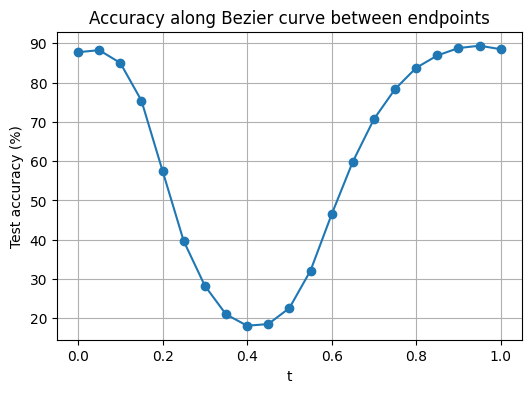

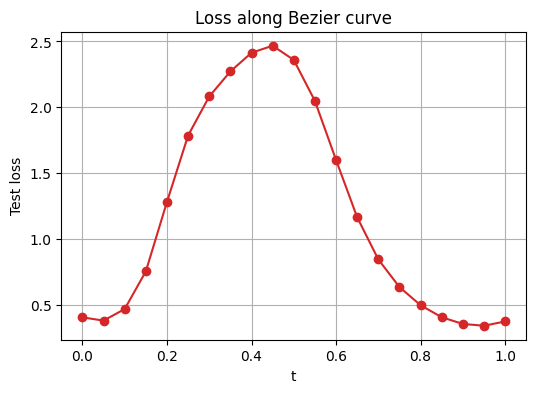

In [11]:
plt.figure(figsize=(6, 4))
plt.plot([entry["t"] for entry in curve_results], [entry["accuracy"] for entry in curve_results], marker="o")
plt.xlabel("t")
plt.ylabel("Test accuracy (%)")
plt.title("Accuracy along Bezier curve between endpoints")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot([entry["t"] for entry in curve_results], [entry["loss"] for entry in curve_results], marker="o", color="tab:red")
plt.xlabel("t")
plt.ylabel("Test loss")
plt.title("Loss along Bezier curve")
plt.grid(True)
plt.show()



In [12]:
import pandas as pd
pd.DataFrame(history)


,epoch,loss,accuracy,mid_acc
0,1,0.597004,82.808,19.98
1,2,0.522367,85.236,21.25
2,3,0.488624,86.196,32.18
3,4,0.465172,87.424,38.23
4,5,0.432251,88.368,51.21
5,6,0.418332,88.874,66.61
6,7,0.417165,88.996,69.79
7,8,0.400711,89.612,70.16
8,9,0.388303,89.964,82.26
9,10,0.385050,90.102,83.59
